In [7]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [8]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [9]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201878
Connected. Call `.close()` to terminate connection gracefully.


In [10]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

Given that the relationships between features and the target variable are complex and nonlinear, we use Extreme Gradient Boosting as a model, in order to capture intricate patterns and interactions in the data.

Finished: Reading data from Hopsworks, using ArrowFlight (2.32s) 


MSE = 0.51


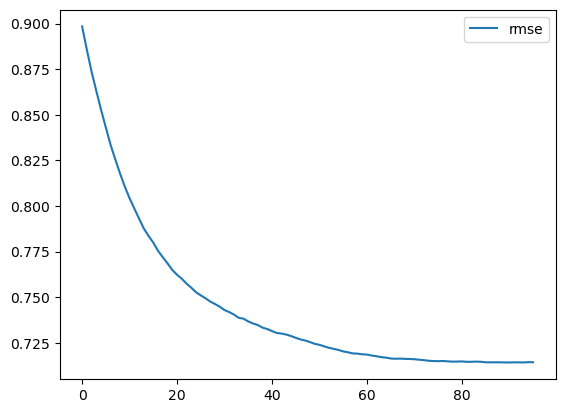

In [11]:
#for extreme gradient boosting
from xgboost import XGBRegressor

#machine learning metrics
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

#creating our model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

#training the data
model.fit(X_train, y_train.values.ravel(), 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

#making our predictions
y_pred = model.predict(X_test)

#getting the mse
model_mse_2 = mean_squared_error(y_test, y_pred)
print("MSE =",(round(model_mse_2,2)))

#getting the training resutls
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='rmse')
# show the legend
plt.legend()
# show the plot
plt.show()

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model to 'model_dir'
joblib.dump(model, model_dir + "/wine_model.pkl")   

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

metrics = {"model_mse": model_mse_2}
# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics=metrics,
    model_schema=model_schema,
    description="Wine quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/201878/models/wine_model/2


Model(name: 'wine_model', version: 2)